# Probabilistic CCA on Mixture

In [59]:
%cd /Users/gwg/local/dmcm
%matplotlib inline

/Users/gwg/local/dmcm


In [60]:
import matplotlib.pyplot as plt
from   matplotlib.offsetbox import OffsetImage, AnnotationBbox

import numpy as np
from   sklearn.decomposition import PCA

from   data   import MixtureConfig, MixtureDataset
from   models import CCAAE
import torch

In [61]:
cfg     = MixtureConfig()

k = 2
cfg.PCCA_Z_DIM = k
N = 2000

dataset = MixtureDataset(cfg)
model   = CCAAE(cfg)

In [62]:
fname = 'test/model.pt'
state = torch.load(fname, map_location={'cuda:0': 'cpu'})
model.load_state_dict(state)

In [73]:
def imscatter(points, images, colors, ax, zoom=1, frameon=True):
   
    for i, (img, color) in enumerate(zip(images, colors)):
        img[0][img[0] == 0] = color[0]
        img[1][img[1] == 0] = 0  # Ignore the green channel. It's just noise.
        img[2][img[2] == 0] = color[2]

    for (x, y), image in zip(points, images):
        try:
            image = np.asarray(Image.fromarray(image).convert('RGB'))
        except:
            pass
        im = OffsetImage(image.T, zoom=zoom)
        ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=frameon)
        ax.add_artist(ab)

# ------------------------------------------------------------------------------

def plot(points, colors, images=False):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(20, 20)

    Xp = points[:, 0]
    Yp = points[:, 1]
    
    ax.set_xlim([Xp.min(), Xp.max()])
    ax.set_ylim([Yp.min(), Yp.max()])
    
    if images:
        images = dataset.images[:N].detach().numpy()
        imscatter(points, images, colors, ax)
    else:
        for xp, yp, c in zip(Xp, Yp, colors):
            if c == 3:
                ct = (1, 0, 0)
            elif c == 4:
                ct = (0, 1, 0)
            elif c == 2:
                ct = (0, 0, 1)
            ax.scatter(xp, yp, c=ct, s=10)

In [74]:
Z = torch.Tensor(cfg.N_SAMPLES, k * 3)
x1 = dataset.images[:N]
x2 = dataset.genes[:N]

y1 = model.image_net.encode(x1)
y2 = model.genes_net.encode(x2)

y1 = y1 - y1.mean(dim=0)
y2 = y2 - y2.mean(dim=0)
y  = torch.cat([y1, y2], dim=1)
y  = y.t()

z = model.cca.estimate_z_given_y(y)
z = z.t()
z     = z.detach().numpy()

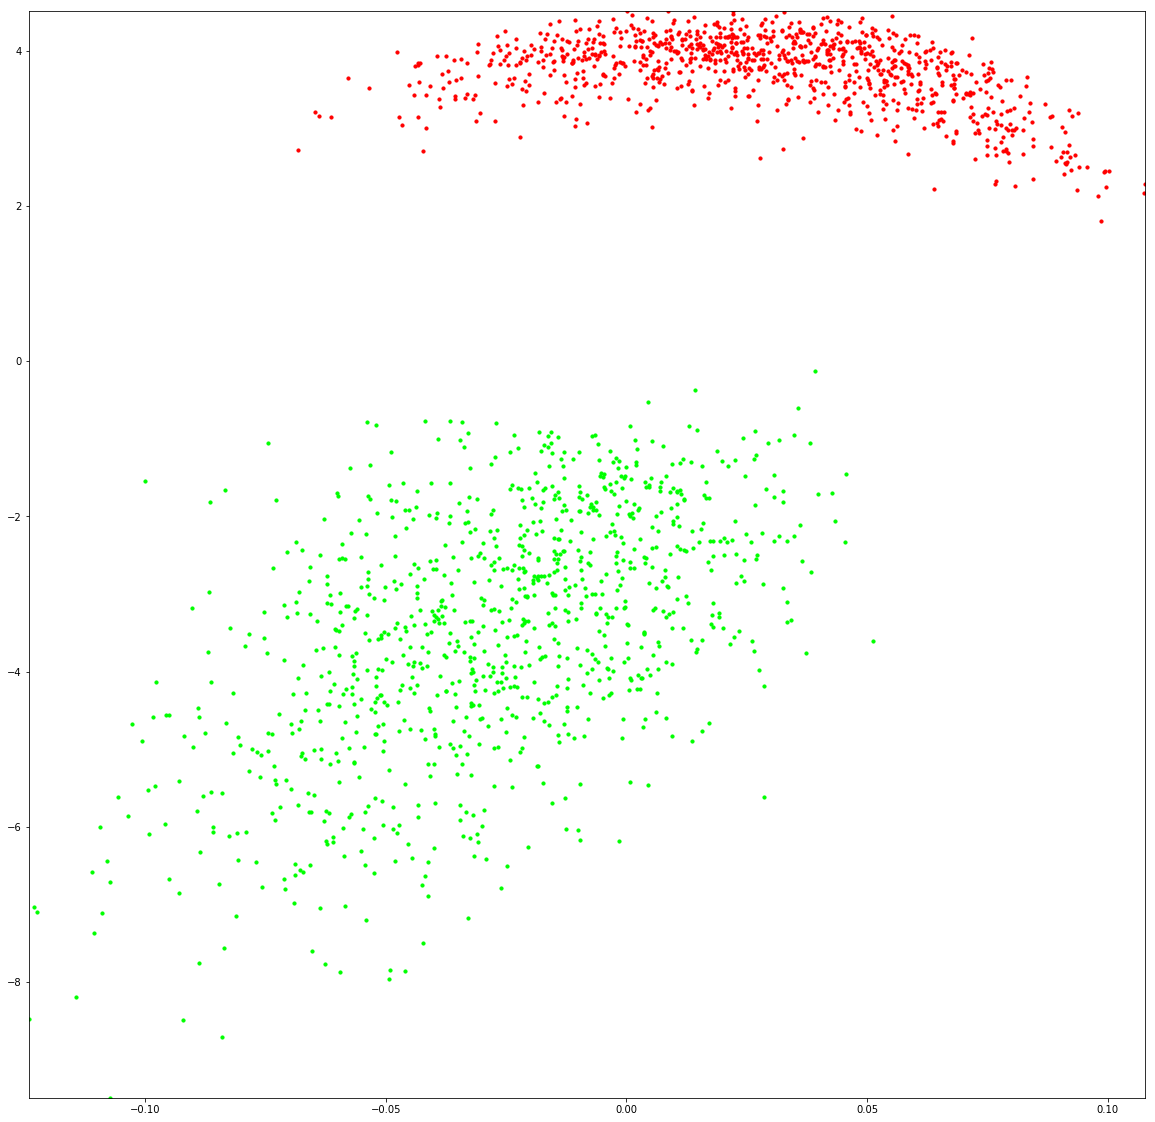

In [75]:
z_all = z
z_c   = z[:, :k]
z_a   = z[:, k:2*k]
z_b   = z[:, 2*k:]

z_ca = np.hstack([z_c, z_a])
z_ca = np.hstack([z_c, z_b])

data = torch.load('data/mixture/train.pth')
zc_labels = data['Zc_labels']
za_labels = data['Za_labels'] + 3
zb_labels = torch.Tensor([5 for _ in range(len(z))])

# pca = PCA(n_components=2)
# z_s1_pca = pca.fit_transform(z_s1)
# pca = PCA(n_components=2)
# z_s2_pca = pca.fit_transform(z_s2)

# colors = x2[:, :3].numpy()
colors = za_labels.numpy().tolist()
# print(colors)
plot(z_a, colors, False)